# Градиентный бустинг

В независимости построения деревьев в случаном лесе кроется и плюс и минус алгоритма: с одной стороны, построение деревьев можно распараллеливать и, например, организовывать на разных ядрах процессора, с другой стороны, следствием их независимости является тот факт, что для решения сложных задач требуется очень большое количество деревьев. В этих случаях случаях (при большой выборке или большом количестве признаков) обучение случайного леса может требовать очень много ресурсов, а если для ограничения их потребления слишком ограничивать глубину деревьев, они могут не уловить все закономерности в данных и иметь большой сдвиг (и, следовательно, ошибку).

Бустинг является своеобразным решением этой проблемы: он заключается в последовательном построении ансамбля, когда деревья строятся одно за другим, и при этом каждое следующее дерево строится таким образом, чтобы исправлять ошибки уже построенного на данный момент ансамбля. При таком подходе базовые алгоритмы могут быть достаточно простыми, то есть можно использовать неглубокие деревья.

### 1. Общий подход градиентного бустинга

Итоговый алгоритм ищется в виде **взвешенной суммы** базовых алгоритмов:

$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

В случае линейной регрессии задача состоит в минимизации среднеквадратичного функционала ошибки:

$$\frac{1}{l}\sum_{i=1}^{l}(a(x_{i}) - y_{i})^{2} \rightarrow \text{min}.$$

Так как ансамбль строится итеративно, нужно вначале обучить первый простой алгоритм:

$$b_{1}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - y_{i})^{2}.$$

Такая задача легко решается методом градиентного спуска.

После того, как мы нашли первый алгоритм $b_{1}(x)$, нам нужно добавить в ансамбль еще один алгоритм $b_{2}(x)$. Для начала найдем разницу ответов первого алгоритма с реальными ответами:

$$s_{i}^{(1)} = y_{i} - b_{1}(x_{i}).$$

Если прибавить эти значения к полученным предсказаниям, получим идеальный ответ. Таким образом, новый алгоритм логично обучать так, чтобы его ответы были максимально близки к этой разнице, чтобы при их прибавлении к ответам первого алгоритма мы получили близкие к реальным. Значит, второй алгоритм будет обучаться на следующем функционале ошибки:

$$b_{2}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(1)})^{2} = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - (y_{i} - b_{1}(x_{i})))^{2}.$$

Каждый следующий алгоритм также настраивается на остатки композиции из предыдущих алгоритмов:

$$b_{N}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(N)})^{2},$$ 

$$s_{i}^{(N)} = y_{i} - \sum_{n=1}^{N-1}b_{n}(x_{i}) = y_{i} - a_{N-1}(x_{i}).$$

Таким образом, каждый новый алгоритм корректирует ошибки предыдущих, и так продолжается до момента получения приемлемой ошибки на композиции. Вектор коэффициентов $s$ при этом называют _вектором сдвига_.

Выбор сдвига из условия $s_{i} = y_{i} - a_{N-1}(x_{i})$ требует точного совпадения полученных предсказаний и ответов, однако, в более общем случае вектор сдвига принимают с учетом особенностей используемой в данном случае функции потерь: вектор сдвига должен ее минимизировать, то есть направлять в сторону уменьшения. Как мы помним из метода градиентного спуска, направление наискорейшего убывания функции совпадает с ее антиградиентом. Таким образом, если при обучении мы минимизируем функционал ошибки $L(y,z)$

$$\sum_{i=1}^{l}L(y_{i}, a_{N-1}(x_{i}) + s_{i}) \rightarrow \underset{s}{\text{min}},$$

сдвиг на каждом шаге должен быть противоположен производной функции потерь в точке $z = a_{N-1}(x_{i})$. 

$$s_{i} = \left.-\frac{\partial L}{\partial z} \right|_{z = a_{N-1}(x_{i})}.$$

Каждый новый алгоритм таким образом выбирается так, чтобы как можно лучше приближать антиградиент ошибки на обучающей выборке. 

После того, как мы вычислили требуемый для минимизации ошибки сдвиг $s$, нужно настроить алгоритм $b_{N}(x)$ так, чтобы он давал максимально близкие к нему ответы, то есть обучать его именно на вектор сдвига. Близость ответов алгоритма к сдвигу обычно оценивается с помощью среднеквадратичной ошибки независимо от условий исхожной задачи (так как исходно используемая функция потерь $L$ уже учтена в сдвигах $s_{i}$):

$$b_{N}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2}.$$

Коэффициент $\gamma$ для найденного алгоритма также находится по аналогии с наискорейшим градиентным спуском:

$$\gamma_{N} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{N-1}(x_{i}) + \gamma b_{N}(x_{i})).$$

Аналогично алгоритму градиентного спуска, имеет смысл добавлять ответ каждого нового алгоритма не полностью, а с некоторым шагом $\eta \in (0, 1]$, так как базовые алгоритмы обычно достаточно простые (например, деревья малой глубины), и они могут плохо приближать вектор антиградиента, и тогда вместо приближения к минимуму мы будем получать случайное блуждание в пространстве. В градиентном бустинге такой прием называется сокращением шага.

$$a_{N}(x) = a_{N-1}(x) + \eta \gamma_{N} b_{N}(x).$$

Градиентный бустинг склонен к переобучению при увеличении числа итераций $N$ или глубины входящих в него деревьев. Стоит об этом помнить при построении алгоритма и выбирать оптимальные параметры по отложенной выборке или с помощью кросс-валидации.

![title](gb.png)

### 2. Алгоритм градиентного бустинга

В конечном итоге алгоритм построения модели градиентного бустинга заключается в следующих шагах:

__1.__ Для инициализации выбирается произвольный простой алгоритм $b_{0}(x)$, в его роли можно брать обычные константные алгоритмы: в случае задачи регрессии это может быть

$$b_{0}(x) = 0$$

или среднее значение по всем объектам обучающей выборки 

$$b_{0}(x) = \frac{1}{l}\sum_{i=1}^{l}y_{i};$$

в случае классификации - самый часто встречающийся в выборке класс

$$b_{0}(x) = \underset{y}{\text{argmax}}\sum_{i=1}^{l}[y_{i} = y].$$

__2.__ Для каждой итерации вычисляется вектор сдвига $s$:

$$s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$$

находится алгоритм

$$b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$$

находится оптимальный коэффициент $\gamma$

$$\gamma_{n} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{n-1}(x_{i}) + \gamma b_{n}(x_{i})).$$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый _скоростью обучения_ (опционально)

$$a_{n}(x) = a_{n-1}(x) + \eta \gamma_{n} b_{n}(x).$$

__3.__ При достижении критериев остановки компонуется итоговая модель.

### 3. Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

### 4. Примеры реализации

Обычно сначала настраивают гиперпараметры базового алгоритма, а потом гиперапараметры композиции(n_estimators, learning_rate).

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [104]:
from gbm import gb_predict
from gbm import gb_fit
from metrics import mean_squared_error
from metrics import bias

In [5]:
from sklearn.datasets import load_diabetes

In [6]:
X, y = load_diabetes(return_X_y=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [9]:
def get_error_plot(hyper, train_err, test_err, x_label, title):
    plt.xlabel(x_label)
    plt.ylabel('MSE')
    plt.xlim(0, hyper)
    plt.plot(list(range(1, hyper+1)), train_err, label='train error')
    plt.plot(list(range(1,hyper+1)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlim(1,hyper+1)
    plt.show()

### 4.1. Зависимость ошибки от количества деревьев в ансамбле

In [112]:
#число деревьев
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.5

In [113]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [114]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 1409.1583310083731
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3870.7011316799535


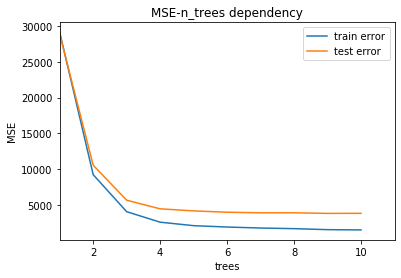

In [115]:
get_error_plot(n_trees, train_errors, test_errors, 'trees', f'MSE-n_trees dependency')

На этом наборе данных видим, что при количестве деревьев, больше 2, качество обучения постепенно начинает падать и зарождается
тенденция к переобучению. Попробуем увеличить количество деревьев.

In [116]:
#число деревьев
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.5

In [117]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [118]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 185.56788536142042
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 4499.042155898608


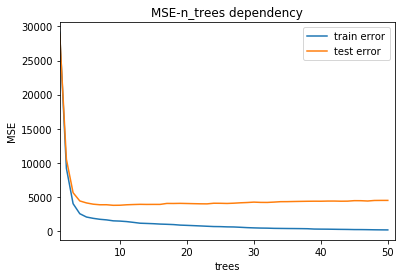

In [119]:
get_error_plot(n_trees, train_errors, test_errors, 'trees', f'MSE-n_trees dependency')

Увеличение количества деревьев не помогло. Ситуация не только не изменилась, но и стала хуже.

### 4.2. Зависимость ошибки от глубины дерева в ансамбле

In [130]:
#примем число деревьев, равное 2
n_trees = 2

#примем глубину, равную 7
max_depth = 7

# Шаг
eta = 0.5

In [131]:
plot_train_errors = []
plot_test_errors = []
    
for value in range(1, max_depth+1):
    trees, train_errors, test_errors = gb_fit(n_trees, value, X_train, X_test, y_train, y_test, coefs, eta)
    plot_train_errors.append(train_errors[-1])
    plot_test_errors.append(test_errors[-1])

In [132]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 2 деревьев глубиной 7     с шагом 0.5 на тренировочной выборке: 2421.431944664197
Ошибка алгоритма из 2 деревьев глубиной 7     с шагом 0.5 на тестовой выборке: 5800.173842803605


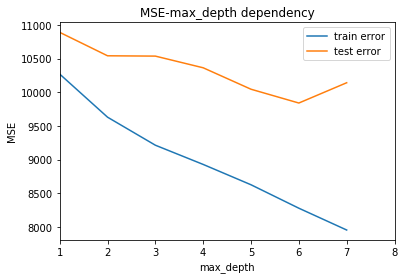

In [133]:
get_error_plot(max_depth, plot_train_errors, plot_test_errors, 'max_depth', f'MSE-max_depth dependency')

На этом графике видим, что глубину дерева лучше сделать минимально возможной. Дисперсия кривых валидации и обучения показывают,
что есть переобучение.

In [138]:
#примем глубину, равную 2
max_depth = 2

In [139]:
plot_train_errors = []
plot_test_errors = []

for value in range(1, max_depth+1):
    trees, train_errors, test_errors = gb_fit(n_trees, value, X_train, X_test, y_train, y_test, coefs, eta)
    plot_train_errors.append(train_errors[-1])
    plot_test_errors.append(test_errors[-1])

In [140]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 2 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 4544.5046452902
Ошибка алгоритма из 2 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 5826.249767011281


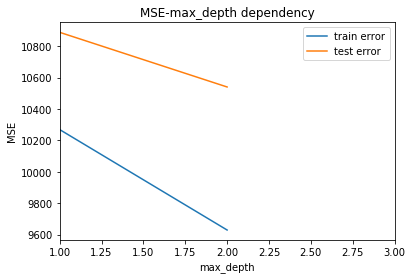

In [141]:
get_error_plot(max_depth, plot_train_errors, plot_test_errors, 'max_depth', f'MSE-max_depth dependency')

Всё ещё есть переобучение, однако дисперсия оценок немного стабилизировалась.

### 4.3. Зависимость ошибки от скорости обучения

Попробуем уменьшить скорость обучения, оставив число деревьев и глубину такой же.

In [142]:
eta = 0.01

In [143]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [144]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 2 деревьев глубиной 2     с шагом 0.01 на тренировочной выборке: 28116.09072484808
Ошибка алгоритма из 2 деревьев глубиной 2     с шагом 0.01 на тестовой выборке: 27910.29091791787


Качество обучения улучшилось, удалось подобрать порядок eta. Попробуем увеличить скорость обучения, придерживаясь найденного 
порядка, для того, чтобы минимизировать MSE.

In [190]:
eta = 0.04

In [191]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [192]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 2 деревьев глубиной 2     с шагом 0.04 на тренировочной выборке: 25221.931239321042
Ошибка алгоритма из 2 деревьев глубиной 2     с шагом 0.04 на тестовой выборке: 25185.73997179792


Получилось минимизировать среднеквадратичную ошибку. Также это подтверждает тезис о том, что сначала лучше настраивать гиперпараметры базового алгоритма.
Например, если бы мы изначально настраивали гиперпараметры композиции, то искали бы антиградиент на неоптимальных гиперпараметрах базового алгоритма. Такая стратегия стродни тому, чтобы выбирать направление движения в тумане.

### 4.4. Стохастический градиентный бустинг

Теперь попробуем стохастическую версию градиентного бустина, который обучается на половине выборки.

In [10]:
from sgbm import sgbm_predict
from sgbm import sgbm_fit

In [13]:
n_trees = 10
coefs = [1] * n_trees
max_depth = 5
batch_size = 2
eta = 0.5

In [14]:
trees, train_errors, test_errors = sgbm_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_size)

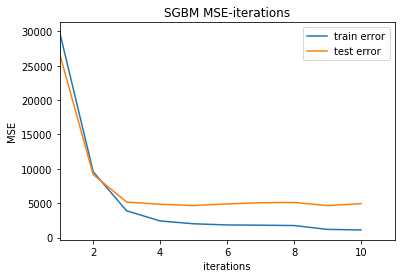

In [18]:
get_error_plot(n_trees, train_errors, test_errors, 'iterations', f'SGBM MSE-iterations')

Стохастическая версия сошлась немного медленне. Но кривые обучения и валидации, начиная с третьего дерева расходятся быстрее.
Это может говорить о том, что нам нужно сделать больше глубоких деревьев при той же скорости обучения.

In [40]:
n_trees = 20
coefs = [1] * n_trees
max_depth = 10
batch_size = 2
eta = 0.04

In [41]:
trees, train_errors, test_errors = sgbm_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_size)

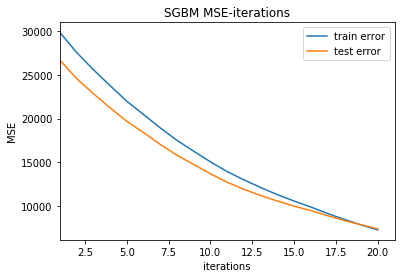

In [42]:
get_error_plot(n_trees, train_errors, test_errors, 'iterations', f'SGBM MSE-iterations')

Либо можно увеличить скорость обучения в два раза, снизив при этом в той же пропорции число и глубину деревьев.

In [43]:
n_trees = 10
coefs = [1] * n_trees
max_depth = 5
batch_size = 2
eta = 0.08

In [44]:
trees, train_errors, test_errors = sgbm_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_size)

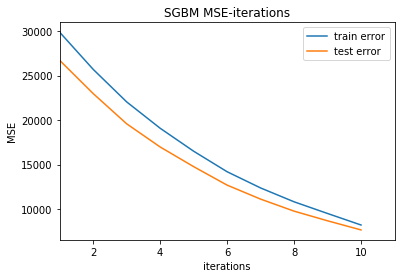

In [45]:
get_error_plot(n_trees, train_errors, test_errors, 'iterations', f'SGBM MSE-iterations')

Заметим, что ошибка при этом снизилась существенно, порядка на 300п.п.